In [18]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# 1. Data

In [20]:
datas = pd.read_csv("datas/movielens_small/ratings.csv")

datas.head()

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

# 2. Data Analysis

In [21]:
# 1. describe (통계 정보 1. value)
datas.describe()

userId        movieId         rating     timestamp
count  100004.000000  100004.000000  100004.000000  1.000040e+05
mean      347.011310   12548.664363       3.543608  1.129639e+09
std       195.163838   26369.198969       1.058064  1.916858e+08
min         1.000000       1.000000       0.500000  7.896520e+08
25%       182.000000    1028.000000       3.000000  9.658478e+08
50%       367.000000    2406.500000       4.000000  1.110422e+09
75%       520.000000    5418.000000       4.000000  1.296192e+09
max       671.000000  163949.000000       5.000000  1.476641e+09

In [22]:
# 2. info (통계 정보 2. data structure)
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [23]:
# 3. 불필요한 칼럼 제거
datas.drop("timestamp", axis=1, inplace=True)
datas.head()

userId  movieId  rating
0       1       31     2.5
1       1     1029     3.0
2       1     1061     3.0
3       1     1129     2.0
4       1     1172     4.0

In [24]:
# 4. unique data set check
print("사용자 수 : {} 명".format(datas['userId'].unique().size))
print("평가된 영화 수 : {} 개".format(datas['movieId'].unique().size))

사용자 수 : 671 명
평가된 영화 수 : 9066 개


# 2. Matrix Factorization

## 1. MF Model Process

In [25]:
# 1. split train and test
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(datas, test_size=0.2, random_state=42)
print("Train dataset shape : {}".format(train_df.shape))
print("Test dataset shape : {}".format(test_df.shape))

Train dataset shape : (80003, 3)
Test dataset shape : (20001, 3)


In [26]:
# 2. set pivot
pivot_df = train_df.pivot_table("rating", index="userId", columns="movieId")
pivot_df.fillna(0, inplace=True)
pivot_df.head()

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  160656  160718  161084  161155  161594  161830  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     4.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  161918  161944  162542  163949  
userId                                   
1           0.0     0.0     0.0     0.0  
2           0.0     0.0     0.0     0.0  
3           0.0     0.0     0.0     0.0  
4           0.0     0.0     0.0     0.0  
5           0.0     0.0     0.0     0.0  

[5 rows x 8399 columns]

In [39]:
# 3. Setting Value
Interaction = pivot_df.to_numpy()

num_user, num_item = Interaction.shape
latent_factor = 20
learning_rate = 0.01
reg = 0.01

In [49]:
# 4. Setting Latent Factor Matrix p_u(사용자), q_i(아이템)
p_u = np.random.normal(size=(num_user, latent_factor))
q_i = np.random.normal(size=(num_item, latent_factor))

print("사용자 수 : {} 명, 사용자 잠재 변수 행렬 shape {}".format(num_user, p_u.shape))
print("영화 수 : {} 개, 영화 잠재 변수 행렬 shape {}".format(num_item, q_i.shape))

사용자 수 : 671 명, 사용자 잠재 변수 행렬 shape (671, 20)
영화 수 : 8399 개, 영화 잠재 변수 행렬 shape (8399, 20)


#### 사용자, 아이템 별로 랜덤한 잠재 변수 행렬이 각 각의 요소의 크기만큼, latent_factor 사이즈 만큼 만들어진 것을 알 수 있음

In [50]:
# 5. Confidence ref.Inputs with varying confidence levels
user_confidence = (pivot_df > 0).sum(axis=1)
item_confidence = (pivot_df > 0).sum(axis=0)

## 사용자의 평점 빈도 수(크기가 될 수 있음) 및 해당 사용자가 평가한 영화의 평점 발생 빈도 수(크기가 될 수 있음)을 더해
### 평가에 대한 신뢰도 부여
confidences = train_df.apply(lambda x: 
                   user_confidence.loc[x['userId']] + 
                   item_confidence.loc[x['movieId']], axis=1)
train_df['confidence'] = confidences
train_df.head()

userId  movieId  rating  confidence
37865     273     5816     4.5         138
46342     339     2028     4.5         229
64614     461     3895     0.5         555
41974     300     3578     4.5         170
50236     369      292     3.0         139

In [51]:
# 6. Set confidence pivot
confidence_df = train_df.pivot_table(values="confidence", index="userId", columns="movieId")
confidence_df.fillna(1, inplace=True)

confidence_matrix = confidence_df.to_numpy()

confidence_df.head()

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
3           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
4           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
5           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

movieId  9       10      ...  160656  160718  161084  161155  161594  161830  \
userId                   ...                                                   
1           1.0     1.0  ...     1.0     1.0     1.0     1.0     1.0     1.0   
2           1.0   163.0  ...     1.0     1.0     1.0     1.0     1.0     1.0   
3           1.0     1.0  ...     1.0     1.0     1.0     1.0     1.0     1.0   
4           1.0     1.0  ...     1.0     1.0     1.0     1.0     1.0     1.0   
5           1.0     1.0  ...     1.0     1.0     1.0     1.0     1.0     1.0   

movieId  161918  161944  162542  163949  
userId                                   
1           1.0     1.0     1.0     1.0  
2           1.0     1.0     1.0     1.0  
3           1.0     1.0     1.0     1.0  
4           1.0     1.0     1.0     1.0  
5           1.0     1.0     1.0     1.0  

[5 rows x 8399 columns]

In [52]:
# 7. scaling confidence matrix
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_confidence = scaler.fit_transform(confidence_matrix)
scaled_confidence += 0.0001
scaled_confidence

array([[1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       ...,
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.00000000e-04, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04],
       [1.38975768e-01, 1.00000000e-04, 1.00000000e-04, ...,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04]])

In [53]:
# 8. bias setting
b_u = np.zeros(num_user)
b_i = np.zeros(num_item)
b = np.mean(Interaction[Interaction != 0])

In [54]:
# 9. test data setting
test_Interaction = test_df.pivot_table("rating", index="userId", columns="movieId")
test_Interaction.fillna(0, inplace=True)
test_Interaction = test_Interaction.to_numpy()

In [55]:
# 10. func get each prediction
def get_each_prediction(i_u, i_i):
    return b + b_u[i_u] + b_i[i_i] + np.dot(p_u[i_u, :], q_i[i_i, :].T)

In [56]:
# 11. func get whole prediction
def get_whole_prediction():
    return b + b_u[:, np.newaxis] + b_i[np.newaxis:,] + np.dot(p_u, q_i.T)

In [57]:
# 12. func gradient_descent
def gradient_descent(i_u, i_i, rating):
    prediction = get_each_prediction(i_u, i_i)
    
    dbu = -2 * scaled_confidence[i_u][i_i] * (rating - b_u[i_u] - b_i[i_i] - b - prediction) + 2 * reg * b_u[i_u]
    dbi = -2 * scaled_confidence[i_u][i_i] * (rating - b_u[i_u] - b_i[i_i] - b - prediction) + 2 * reg * b_i[i_i]
    
    b_u[i_u] -= learning_rate * dbu
    b_i[i_i] -= learning_rate * dbi
    
    dp = -2 * scaled_confidence[i_u][i_i] * \
             (rating - b_u[i_u] - b_i[i_i] - b - prediction) * q_i[i_i,:] + 2 * (reg * p_u[i_u, :])
    dq = -2 * scaled_confidence[i_u][i_i] * \
             (rating - b_u[i_u] - b_i[i_i] - b - prediction) * p_u[i_u,:] + 2 * (reg * q_i[i_i, :])
    
    p_u[i_u, :] -= learning_rate * dp
    q_i[i_i, :] -= learning_rate * dq

In [58]:
# 13. loss function
def test_loss():
    xi, yi = test_Interaction.nonzero()
    predicted = get_whole_prediction()
    test_loss = 0
    for x, y in zip(xi, yi):
        test_loss += np.power(test_Interaction[x, y] - predicted[x, y], 2)
    return np.sqrt(test_loss) / len(xi)

def loss():
    xi, yi = Interaction.nonzero()
    predicted = get_whole_prediction()
    test_loss = 0
    for x, y in zip(xi, yi):
        test_loss += np.power(Interaction[x, y] - predicted[x, y], 2)
    return np.sqrt(test_loss) / len(xi)

In [59]:
# 14. fitting
epoch = 30
for _epoch in range(epoch):
    for i_u in range(num_user):
        for i_i in range(num_item):
            if Interaction[i_u, i_i] > 0:
                gradient_descent(i_u, i_i, Interaction[i_u, i_i])
    _loss = loss()
    _test_loss = test_loss()
    
    print("Epoch: {} ; loss = {} ; test_loss = {}".format(_epoch + 1, _loss, _test_loss))

Epoch: 1 ; loss = 0.009908451255751568 ; test_loss = 0.02168357467899588
Epoch: 2 ; loss = 0.008970307881201829 ; test_loss = 0.020068995351330998
Epoch: 3 ; loss = 0.008497712564426097 ; test_loss = 0.019237058673292427
Epoch: 4 ; loss = 0.008205000604334852 ; test_loss = 0.018711594173581106
Epoch: 5 ; loss = 0.008004118601132386 ; test_loss = 0.01834463046605824
Epoch: 6 ; loss = 0.007857165956815957 ; test_loss = 0.01807168065944874
Epoch: 7 ; loss = 0.00774482225098884 ; test_loss = 0.017859521261675188
Epoch: 8 ; loss = 0.007656094385825095 ; test_loss = 0.017689102964764315
Epoch: 9 ; loss = 0.007584227735799867 ; test_loss = 0.01754865306091713
Epoch: 10 ; loss = 0.0075248281993064055 ; test_loss = 0.01743047799173809
Epoch: 11 ; loss = 0.007474908398566876 ; test_loss = 0.017329327420218348
Epoch: 12 ; loss = 0.007432364570437041 ; test_loss = 0.017241491974333233
Epoch: 13 ; loss = 0.007395671842791646 ; test_loss = 0.017164275335691426
Epoch: 14 ; loss = 0.007363697896438717

## 2. Use

In [60]:
# 1. model setting
from model import MatrixFactorization

train_df, test_df = train_test_split(datas, test_size=0.2, random_state=42)
model = MatrixFactorization(train_df, test_df)

2023-01-12 15:41:42.162050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [61]:
# 2. Train
model.fit(20)

Epoch: 1 ; loss = 0.009791969606255764 ; test_loss = 0.021040518173376654
Epoch: 2 ; loss = 0.008902098004973139 ; test_loss = 0.019631509755824065
Epoch: 3 ; loss = 0.008456977465287343 ; test_loss = 0.018918217882344195
Epoch: 4 ; loss = 0.008180739047867466 ; test_loss = 0.018464741305502647
Epoch: 5 ; loss = 0.007990304925710208 ; test_loss = 0.018143753205062278
Epoch: 6 ; loss = 0.007850371352860028 ; test_loss = 0.01790136971560333
Epoch: 7 ; loss = 0.007742967536514648 ; test_loss = 0.01771021459797633
Epoch: 8 ; loss = 0.007657839473053429 ; test_loss = 0.017554607372233348
Epoch: 9 ; loss = 0.007588661501495991 ; test_loss = 0.017424806746057432
Epoch: 10 ; loss = 0.007531303444274353 ; test_loss = 0.017314395608890962
Epoch: 11 ; loss = 0.0074829492010346724 ; test_loss = 0.017218955073087402
Epoch: 12 ; loss = 0.0074416113597896745 ; test_loss = 0.017135334537328368
Epoch: 13 ; loss = 0.007405847174498641 ; test_loss = 0.01706122346740821
Epoch: 14 ; loss = 0.00737458415262

    epoch  train_loss  test_loss
0       0    0.008745   0.019401
1       1    0.008350   0.018710
2       2    0.008098   0.018263
3       3    0.007921   0.017946
4       4    0.007790   0.017708
5       5    0.007689   0.017522
6       6    0.007608   0.017371
7       7    0.007543   0.017247
8       8    0.007488   0.017142
9       9    0.007442   0.017052
10     10    0.007403   0.016973
11     11    0.007369   0.016905
12     12    0.007339   0.016843
13     13    0.007313   0.016788
14     14    0.007290   0.016739
15     15    0.007269   0.016693
16     16    0.007251   0.016652
17     17    0.007234   0.016614
18     18    0.007218   0.016578
19     19    0.007204   0.016545


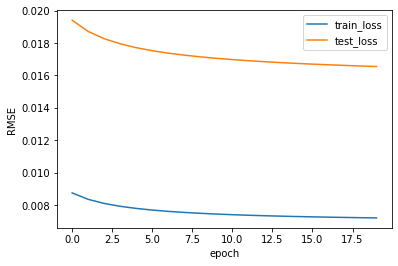

In [207]:
# #. Result
history = model.history

df = pd.DataFrame(history)
df.columns= ["epoch","train_loss","test_loss"]
print(df)
df.loc[:][["train_loss","test_loss"]].plot()
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()